In [205]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

from datetime import datetime

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

from ehr_ml.clmbr import PatientTimelineDataset
from ehr_ml.timeline import TimelineReader

import yaml
import os
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [206]:
# constant variables
cuda_device='cuda:4'
seed = 44
hparams_fpath = "/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/hyperparams"
extract_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/extracts/20210723'
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models'
cohort_fpath = "/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/cohort"
pt_info_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/pretrained/info/info.json'
labelled_path = "/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/labelled_data"

dataset = pd.read_parquet(os.path.join(cohort_fpath, "cohort_split.parquet"))

In [207]:
tlr = TimelineReader(extract_path + '/extract.db', False)

In [208]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    if union == 0:
        return 0
    return float(intersection) / union

In [209]:
def load_data():
    """
    Load datasets from split csv files.
    """

    data_path = f'{labelled_path}/hospital_mortality/pretrained/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01'


    train_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_train.csv')
  
    train_pids['pids'] = train_pids['0']

    train_days = pd.read_csv(f'{data_path}/day_indices_train.csv')
    train_days['days'] = train_days['0']

    #train_data = (train_labels.to_numpy().flatten(),train_pids.to_numpy().flatten(),train_days.to_numpy().flatten())

    return pd.concat((train_pids['pids'], train_days['days']),axis=1)

In [210]:
pid_day_df = load_data()

In [211]:
pat_info_df = pd.read_csv(f'{model_path}/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_1000_lr_1e-5_temp_0.01_pool_rand_day/25/pat_info.csv')
tr_pred_df = pd.read_csv(f'{model_path}/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_1000_lr_1e-5_temp_0.01_pool_rand_day/25/train_preds.csv')
v_pred_df = pd.read_csv(f'{model_path}/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_1000_lr_1e-5_temp_0.01_pool_rand_day/25/val_preds.csv')

,epoch,preds,labels
0,25,70.369670,1.0
1,25,-9.603837,0.0
2,25,2.382825,0.0
3,25,-0.977539,0.0
4,25,-8.944401,0.0
...,...,...,...
524034,25,-5.257938,0.0
524035,25,7.871905,0.0
524036,25,7.617527,0.0
524037,25,1.519446,0.0


In [213]:
df = tr_pred_df[['preds', 'labels']].groupby('labels').mean()
print('Mean prediction by label')
print(df)
df = tr_pred_df[['preds', 'labels']].groupby('labels').median()
print('Median prediction by label')
print(df)
df = tr_pred_df[['preds', 'labels']].groupby('labels').min()
print('Min prediction by label')
print(df)
df = tr_pred_df[['preds', 'labels']].groupby('labels').max()
print('Max prediction by label')
print(df)

Mean prediction by label
            preds
labels           
0.0      0.131692
1.0     65.004660
Median prediction by label
            preds
labels           
0.0     -0.410377
1.0     76.354320
Min prediction by label
            preds
labels           
0.0    -31.608625
1.0    -20.599049
Max prediction by label
        preds
labels       
0.0     100.0
1.0     100.0


[0.00000000e+00 1.92623440e-04 1.92623440e-04 ... 9.99887636e-01
 9.99887636e-01 1.00000000e+00]
[0.         0.00161446 0.01301802 ... 0.99998863 1.         1.        ]
[101.       100.        85.66343  ... -20.54805  -20.599049 -31.608625]
35658
AUROC: 0.9416196821386464


Text(0, 0.5, 'TPR')

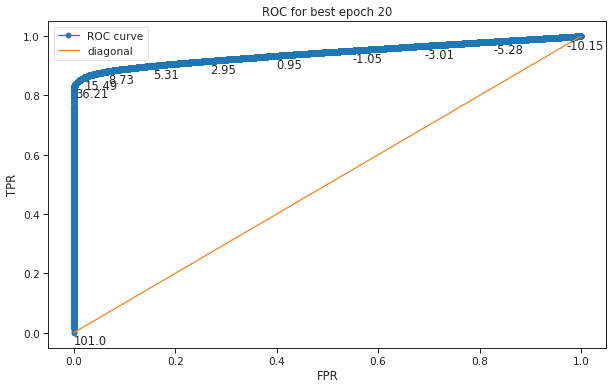

In [214]:
df = tr_pred_df[['preds', 'labels']]

fpr, tpr, thresh = roc_curve(list(df['labels']), list(df['preds']))
print(fpr)
print(tpr)
print(thresh)
print(len(thresh))
print('AUROC:',roc_auc_score(list(df['labels']),list(df['preds'])))
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::3500], tpr[::3500], thresh[::3500]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.title(f'ROC for best epoch 20')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

[0.         0.         0.         ... 0.99973496 0.99973941 1.        ]
[0.         0.00301121 0.01637509 ... 1.         1.         1.        ]
[2.         1.         0.89106664 ... 0.09622375 0.09601773 0.        ]
8049
AUROC: 1.0


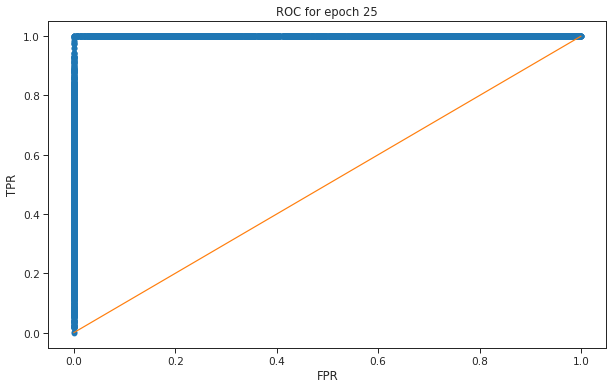

In [218]:
for epoch in [25]:#tr_pred_df['epoch'].unique():
    df = pred_df[['preds', 'adjust_labels']]

    fpr, tpr, thresh = roc_curve(list(df['adjust_labels']), list(df['preds']))
    print(fpr)
    print(tpr)
    print(thresh)
    print(len(thresh))
    print('AUROC:',roc_auc_score(list(df['adjust_labels']),list(df['preds'])))
    plt.subplots(figsize=(10, 6))
    plt.plot(fpr, tpr, 'o-', label="ROC curve")
    plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
    plt.title(f'ROC for epoch {epoch}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

In [216]:
#for e in tr_pred_df['epoch'].unique():
pred_df = tr_pred_df.reset_index(drop=True)
pred_df['preds'] = (pred_df['preds'] - pred_df['preds'].min())/(pred_df['preds'].max() - pred_df['preds'].min())
print('AUROC:',roc_auc_score(list(pred_df['labels']),list(pred_df['preds'])))
pred_df['adjust_labels'] = np.where(pred_df['preds'] > 0.5, 1, 0)
print('AUROC:',roc_auc_score(list(pred_df['adjust_labels']),list(pred_df['preds'])))
pat_df = pat_info_df.query('phase == "train"').reset_index(drop=True)

AUROC: 0.9416196821386464
AUROC: 1.0


In [219]:
pred_df[pred_df['labels'] != pred_df['adjust_labels']]

,epoch,preds,labels,adjust_labels
144,25,0.209347,1.0,0
162,25,0.262938,1.0,0
858,25,0.220524,1.0,0
894,25,0.258478,1.0,0
1002,25,0.389518,1.0,0
...,...,...,...,...
523852,25,0.257847,1.0,0
523858,25,0.257742,1.0,0
523870,25,0.375698,1.0,0
523888,25,0.279221,1.0,0


In [220]:
ehr_pat_ids = list(tlr.get_patient_ids())
og_pat_ids = list(tlr.get_original_patient_ids())

In [221]:
num_pos = len(pred_df.query('labels==1'))
num_neg = len(pred_df.query('labels==0'))
tp = len(pred_df.query('labels==1 and adjust_labels==1'))
tn = len(pred_df.query('labels==0 and adjust_labels==0'))
fp = len(pred_df.query('labels==0 and adjust_labels==1'))
fn = len(pred_df.query('labels==1 and adjust_labels==0'))
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
print(f'# +ve: {num_pos}, #-ve: {num_neg}')

TP: 73596, FP: 1457, TN: 434627, FN: 14359
# +ve: 87955, #-ve: 436084


In [222]:
fp_df = pred_df.query('labels==0 and adjust_labels==1')
fn_df = pred_df.query('labels==1 and adjust_labels==0')
tn_df = pred_df.query('labels==0 and adjust_labels==0').sample(n=2000)

In [224]:
pat_df.head()

,left_id,left_idx,left_max_idx,right_id,right_idx,right_max_idx,epoch,phase
0,495484,4,119,495484,4,119,25,train
1,495484,4,119,1042272,35,119,25,train
2,495484,4,119,1933916,11,119,25,train
3,495484,4,119,1042272,99,119,25,train
4,495484,4,119,2064164,57,119,25,train


In [235]:
j_sim = []
pred_vals = []
age_diff = []
race_match = []
gender_match = []
day_diff = []
p1_num_code = []
p2_num_code = []


# look at overall patient codes for timeline


for i in range(len(fp_df)):
    p1_codeset = []
    p2_codeset = []
    fp_pred = fp_df['preds'].iloc[i]
    
    idx = fp_df.iloc[[i]].index.values[0]
    p1_id = pat_df['left_id'].loc[idx]
    p1_idx = pat_df['left_idx'].loc[idx]
    p1_max_idx = pat_df['left_max_idx'].loc[idx]
    p2_id = pat_df['right_id'].loc[idx]
    p2_idx = pat_df['right_idx'].loc[idx]
    p2_max_idx = pat_df['right_max_idx'].loc[idx]
    
    
    p1_id_day_df = pid_day_df.query('pids==@p1_id')
    p2_id_day_df = pid_day_df.query('pids==@p2_id')

    p1_og_id = og_pat_ids[ehr_pat_ids.index(p1_id)]
    p1_df = dataset.query('person_id==@p1_og_id')
    p2_og_id = og_pat_ids[ehr_pat_ids.index(p2_id)]
    p2_df = dataset.query('person_id==@p2_og_id')

    p1 = tlr.get_patient(p1_id)
    p2 = tlr.get_patient(p2_id)
    
    p1_days = list(p1.days)[:p1_max_idx]
    p2_days = list(p2.days)[:p2_max_idx]
    
    if p1_idx >= len(p1_days):
        print(p1_idx)
        print(len(p1_days))
        print(p1_max_idx)
        continue
    if p2_idx >= len(p2_days):
        print(p2_idx)
        print(len(p2_days))
        print(p2_max_idx)
        continue
    
    pred_vals.append(fp_pred)
    p1_day = p1_days[p1_idx]
    p2_day = p2_days[p2_idx]
    
    day_diff.append(np.abs(p1_id_day_df['days'].values[0]-p2_id_day_df['days'].values[0]))
    
    
    age_diff.append(np.abs(p1_day.age - p2_day.age)/365)
    
    if p1_df['race_eth'].unique()[0] == p2_df['race_eth'].unique()[0]:
        race_match.append(1)
    else:
        race_match.append(0)
    
    if p1_df['gender_concept_name'].unique()[0] == p2_df['gender_concept_name'].unique()[0]:
        gender_match.append(1)
    else:
        gender_match.append(0)
    
    p1_codes = []
    p2_codes = []
    
    for day in list(p1_days):
        p1_codes.extend(list(day.observations))
    for day in list(p2_days):
        p2_codes.extend(list(day.observations))
    
    p1_codes = list(set(p1_codes))
    p2_codes = list(set(p2_codes))
    j_sim.append(jaccard(p1_codes,p2_codes))
    p1_num_code.append(len(p1_codes))
    p2_num_code.append(len(p2_codes))

fp_comp_df = pd.DataFrame({'pred_val':pred_vals,'jaccard':j_sim, 'p1_num_code':p1_num_code, 'p2_num_code':p2_num_code, 'age_diff':age_diff, 'day_diff':day_diff, 'race_match':race_match, 'gender_match':gender_match})

2
2
3


In [236]:
j_sim = []
pred_vals = []
age_diff = []
race_match = []
gender_match = []
day_diff = []
p1_num_code = []
p2_num_code = []


# look at overall patient codes for timeline


for i in range(len(tn_df)):
    p1_codeset = []
    p2_codeset = []
    tn_pred = tn_df['preds'].iloc[i]
    
    idx = tn_df.iloc[[i]].index.values[0]
    p1_id = pat_df['left_id'].loc[idx]
    p1_idx = pat_df['left_idx'].loc[idx]
    p1_max_idx = pat_df['left_max_idx'].loc[idx]
    p2_id = pat_df['right_id'].loc[idx]
    p2_idx = pat_df['right_idx'].loc[idx]
    p2_max_idx = pat_df['right_max_idx'].loc[idx]
    
    
    p1_id_day_df = pid_day_df.query('pids==@p1_id')
    p2_id_day_df = pid_day_df.query('pids==@p2_id')

    p1_og_id = og_pat_ids[ehr_pat_ids.index(p1_id)]
    p1_df = dataset.query('person_id==@p1_og_id')
    p2_og_id = og_pat_ids[ehr_pat_ids.index(p2_id)]
    p2_df = dataset.query('person_id==@p2_og_id')

    p1 = tlr.get_patient(p1_id)
    p2 = tlr.get_patient(p2_id)
    
    p1_days = list(p1.days)[:p1_max_idx]
    p2_days = list(p2.days)[:p2_max_idx]
    
    if p1_idx >= len(p1_days):
        print(p1_idx)
        print(len(p1_days))
        print(p1_max_idx)
        continue
    if p2_idx >= len(p2_days):
        print(p2_idx)
        print(len(p2_days))
        print(p2_max_idx)
        continue
    
    pred_vals.append(fp_pred)
    p1_day = p1_days[p1_idx]
    p2_day = p2_days[p2_idx]
    
    day_diff.append(np.abs(p1_id_day_df['days'].values[0]-p2_id_day_df['days'].values[0]))
    
    
    age_diff.append(np.abs(p1_day.age - p2_day.age)/365)
    
    if p1_df['race_eth'].unique()[0] == p2_df['race_eth'].unique()[0]:
        race_match.append(1)
    else:
        race_match.append(0)
    
    if p1_df['gender_concept_name'].unique()[0] == p2_df['gender_concept_name'].unique()[0]:
        gender_match.append(1)
    else:
        gender_match.append(0)
    
    p1_codes = []
    p2_codes = []
    
    for day in list(p1_days):
        p1_codes.extend(list(day.observations))
    for day in list(p2_days):
        p2_codes.extend(list(day.observations))
    
    p1_codes = list(set(p1_codes))
    p2_codes = list(set(p2_codes))
    j_sim.append(jaccard(p1_codes,p2_codes))
    p1_num_code.append(len(p1_codes))
    p2_num_code.append(len(p2_codes))

tn_comp_df = pd.DataFrame({'pred_val':pred_vals,'jaccard':j_sim, 'p1_num_code':p1_num_code, 'p2_num_code':p2_num_code, 'age_diff':age_diff, 'day_diff':day_diff, 'race_match':race_match, 'gender_match':gender_match})

In [239]:
race_match_per = fp_comp_df['race_match'].sum()/len(fp_comp_df)
print('Percent FP race matches:',race_match_per)
gender_match_per = fp_comp_df['gender_match'].sum()/len(fp_comp_df)
print('Percent FP gender matches:',gender_match_per)
avg_age_diff = fp_comp_df['age_diff'].mean()
print('FP average age difference:',avg_age_diff)
med_age_diff = fp_comp_df['age_diff'].median()
print('FP median age difference:',med_age_diff)
avg_day_diff = fp_comp_df['day_diff'].mean()
print('FP average timeline length difference:',avg_day_diff)
med_day_diff = fp_comp_df['day_diff'].median()
print('FP median timeline length difference:',med_day_diff)

avg_jac_sim = fp_comp_df['jaccard'].mean()
print('FP average jaccard similarity:',avg_jac_sim)
med_jac_sim = fp_comp_df['jaccard'].median()
print('FP median jaccard similarity:',med_jac_sim)

avg_code_diff = np.abs(fp_comp_df['p1_num_code']-fp_comp_df['p2_num_code']).mean()
print('FP average total code diff:',avg_code_diff)
med_code_diff = np.abs(fp_comp_df['p1_num_code']-fp_comp_df['p2_num_code']).median()
print('FP median total code diff:',med_code_diff)


Percent FP race matches: 0.3516483516483517
Percent FP gender matches: 0.540521978021978
FP average age difference: 4.551369863013699
FP median age difference: 0.0
FP average timeline length difference: 0.007554945054945055
FP median timeline length difference: 0.0
FP average jaccard similarity: 0.28952479865266717
FP median jaccard similarity: 0.2849701778533452
FP average total code diff: 44.46634615384615
FP median total code diff: 34.0


In [240]:
race_match_per = tn_comp_df['race_match'].sum()/len(tn_comp_df)
print('Percent TN race matches:',race_match_per)
gender_match_per = tn_comp_df['gender_match'].sum()/len(tn_comp_df)
print('Percent TN gender matches:',gender_match_per)
avg_age_diff = tn_comp_df['age_diff'].mean()
print('TN average age difference:',avg_age_diff)
med_age_diff = tn_comp_df['age_diff'].median()
print('TN median age difference:',med_age_diff)
avg_day_diff = tn_comp_df['day_diff'].mean()
print('TN average timeline length difference:',avg_day_diff)
med_day_diff = tn_comp_df['day_diff'].median()
print('TN median timeline length difference:',med_day_diff)

avg_jac_sim = tn_comp_df['jaccard'].mean()
print('TN average jaccard similarity:',avg_jac_sim)
med_jac_sim = tn_comp_df['jaccard'].median()
print('TN median jaccard similarity:',med_jac_sim)

avg_code_diff = np.abs(tn_comp_df['p1_num_code']-tn_comp_df['p2_num_code']).mean()
print('TN average total code diff:',avg_code_diff)
med_code_diff = np.abs(tn_comp_df['p1_num_code']-tn_comp_df['p2_num_code']).median()
print('TN median total code diff:',med_code_diff)

#Ask Ethan
# - Dataloader always takes patients of same number of days, or does it try to pad patients with only a couple less days
# - If there is a tail of many patients with only a small number of days, does it stick these all together to form one big batch of patients with only 2-3 days each
# - 


Percent TN race matches: 0.386
Percent TN gender matches: 0.5155
TN average age difference: 27.789046575342464
TN median age difference: 22.854794520547944
TN average timeline length difference: 0.0235
TN median timeline length difference: 0.0
TN average jaccard similarity: 0.2441567673762513
TN median jaccard similarity: 0.2478446674098848
TN average total code diff: 61.2455
TN median total code diff: 47.0


In [144]:
fp_comp_df

,pred_val,jaccard,p1_num_code,p2_num_code,age_diff,day_diff,race_match,gender_match
0,0.190555,1.0,245,245,0.0,0,1,1
1,0.250424,1.0,225,225,0.0,0,1,1
2,0.209846,1.0,409,409,0.0,0,1,1
3,0.463853,1.0,195,195,0.0,0,1,1
4,0.148795,1.0,210,210,0.0,0,1,1
...,...,...,...,...,...,...,...,...
14321,0.319306,1.0,141,141,0.0,0,1,1
14322,0.343897,1.0,107,107,0.0,0,1,1
14323,0.276724,1.0,254,254,0.0,0,1,1
14324,0.241394,1.0,198,198,0.0,0,1,1


In [147]:
race_match_per = fn_comp_df['race_match'].sum()/len(fn_comp_df)
print('Percent FN race matches:',race_match_per)
gender_match_per = fn_comp_df['gender_match'].sum()/len(fn_comp_df)
print('Percent FN gender matches:',gender_match_per)
avg_age_diff = fn_comp_df['age_diff'].mean()
print('FN average age difference:',avg_age_diff)
med_age_diff = fn_comp_df['age_diff'].median()
print('FN median age difference:',med_age_diff)
avg_day_diff = fn_comp_df['day_diff'].mean()
print('FN average timeline length difference:',avg_day_diff)
med_day_diff = fn_comp_df['day_diff'].median()
print('FN median timeline length difference:',med_day_diff)

avg_jac_sim = fn_comp_df['jaccard'].mean()
print('FN average jaccard similarity:',avg_jac_sim)
med_jac_sim = fn_comp_df['jaccard'].median()
print('FN median jaccard similarity:',med_jac_sim)

avg_code_diff = np.abs(fn_comp_df['p1_num_code']-fn_comp_df['p2_num_code']).mean()
print('FN average total code diff:',avg_code_diff)
med_code_diff = np.abs(fn_comp_df['p1_num_code']-fn_comp_df['p2_num_code']).median()
print('FN average total code diff:',med_code_diff)


Percent FN race matches: 1.0
Percent FN gender matches: 1.0
FN average age difference: 0.0
FN median age difference: 0.0
FN average timeline length difference: 0.0
FN median timeline length difference: 0.0
FN average jaccard similarity: 1.0
FN median jaccard similarity: 1.0
FN average total code diff: 0.0
FN average total code diff: 0.0


In [ ]:
fp_comp_df.query('pred_val >= 0.99')